# Shift-invariance

In [1]:
import numpy as np
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

We're now ready to start reasoning abstractly about systems.
This topic can be challenging for students without much mathematical training.
If this part seems difficult to you, that's normal: this topic is not easy!
The most important things to keep in mind are what we're trying to do, and why we're doing it.

In this section, we'll define the property of *shift-invariance* (sometimes also called *time-invariance*), and see some examples of systems with and without this property.
Being able to determine whether a system is shift-invariant can help you understand how the system works, and how it can be combined with other systems (e.g., within an effect chain).

In the bigger picture, shift-invariance is one of the key characteristics of convolutional systems, which is why we study it here.


$$
\require{cancel}\notag%
\require{color}\notag%
\require{amsmath}\notag%%
$$

## Defining shift-invariance
Let $g$ be an arbitrary system, and let

$$
\Delta_d = [\underbrace{0, 0, \dots, 0}_{d \text{ times}}, 1]
$$

denote a $d$-step delay, so that convolving a signal $x$ with $\Delta_d$ yields

$$
(\Delta_d * x)[n] = x[n-d].
$$

We say that $g$ is **shift-invariant** if for all delays $d$ and all input signals $x$, the following is true:

$$
g(\Delta_d * x) = \Delta_d * g(x).
$$

In plain language, this says that if we delay $x$ by $d$ samples, and then process the delayed signal by the system $g$, we will get the exact same result as if we had first applied $g$ to $x$ (without delay) and then delayed the result.

### Shift-invariance or time-invariance?
The term *time-invariant* is also commonly used to describe the property above.
There are two reasons why shift-invariance is a more precise term:

1. "Time-invariant" does not describe what transformation of time the system is invariant to.  Shifting is one transformation, but so is stretching (e.g., changing units from seconds to milliseconds), reversal, or any number of other actions.

2. "Shift-invariant" can be applied to systems operating on other kinds of signals, such as images, which may have different notions of "position" than time (e.g., pixel coordinates).

For these reasons, we'll stick to the more precise terminology, but you are likely to encounter the *time-invariant* terminology elsewhere, so remember that these are the same thing.

## Examples of shift-invariant systems

The first two examples we saw in the previous section are both shift-invariant:
- Gain: $y[n] = G \cdot x[n]$
- Clipping: $y[n] = \mathrm{clip}(x[n], v_-, v_+)$

This is because they both apply the same process uniformly to all samples, and this process depends only on the value of the signal $x[n]$, and not its sample index $n$.

As a general rule, **all convolutional systems are shift-invariant**.

The converse is not true though: not all shift-invariant systems are convolutional.  The clipping system, for example, is shift-invariant, but it cannot be implemented by convolution.

## Examples of non-shift-invariant systems

Not all systems are shift-invariant though.  For example, the time-reversal system 

$$
y[n] = x[N-1-n]
$$

is not shift-invariant.  We can see this from the plot below, where a 5-step delay is applied either before or after the time-reversal system.
Because the two choices lead to two different output signals, we deduce that the system cannot be shift-invariant.

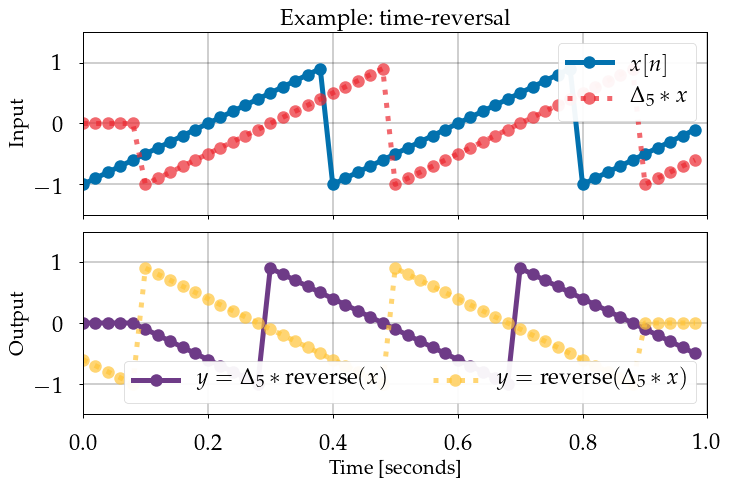

In [4]:
import scipy.signal

fs = 50
f0 = 2.5
duration = 1
times = np.arange(duration * fs) / fs
h = np.array([0,0,0,0,0,1])
x = scipy.signal.sawtooth(2 * np.pi * f0 * times)
x_delay = np.convolve(x, h)[:len(x)]
y = x[::-1]
y_delay = np.convolve(y, h)[:len(y)]
y_delay2 = x_delay[::-1]


fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))
ax.plot(times, x, label='$x[n]$', marker='o', markersize=10)
ax.plot(times, x_delay, label='$\Delta_5*x$', linestyle=':',
          marker='o', markersize=10, alpha=0.7)
ax.label_outer()
ax.legend(loc='upper right')
ax.set_ylabel('Input')
ax.set_title('Example: time-reversal')

ax2.plot(times, y_delay, label=r'$y = \Delta_5*\mathrm{reverse}(x)$', 
           color=colors[4], marker='o', markersize=10)
ax2.plot(times, y_delay2, label=r'$y = \mathrm{reverse}(\Delta_5*x)$', 
           color=colors[2], linestyle=':', marker='o', markersize=10, alpha=0.7)
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlabel('Time [seconds]')
ax2.legend(loc='lower right', ncol=2)
ax2.set_ylabel('Output');

## How to determine shift-invariance

If you're given a new system $g$, it may or may not be shift-invariant.
Determining shift-invariance can require a bit of ingenuity and/or mathematical insight, and if you have no idea where to start, it can seem a bit daunting.

Here we'll show how to prove or disprove shift-invariance: these require different approaches.
In general, it's a good idea to try disproving first, as doing so often reveals some insight about the system in question.

### Proving that a system is shift-invariant

To prove that a system $g$ is shift-invariant, it helps to break down the statement of the definition:
- For **any signal** $x$,
- and for **any delay** $d$,
- $g(\Delta_d * x) = \Delta_d * g(x)$.

Because the statement must hold for all choices of $x$ and $d$, any argument for shift-invariance cannot depend on specific choices for the signal or delay.
This means that we cannot use the counter-example approach used above to show that time-reversal is not shift-invariant.
Instead, we must reason more abstractly about how $g$ works, and proofs of shift-invariance usually follow by algebraic manipulation without making any assumptions about $x$ or $d$.

The general outline of the proof strategy is to fix an arbitrary input signal $x$ and delay $d$, then start from one side of the equation (e.g., $g(\Delta_d * x)$) and manipulate it into a form that is equivalent to the the other side of the equation ($\Delta_d * g(x)$).

#### Example: Gain

We previously asserted that the gain system is shift-invariant, but now let's prove it.

Let $y = g(x)$ denote a gain system, so that $y[n] = G \cdot x[n]$ (for some arbitrary but fixed value $G$).
Let $d \geq 0$ denote an arbitary (but unknown) delay.
Then the $n$th output sample of the system is given by

$$
\begin{align*}
g(\Delta_d * x)[n] &= G \cdot \left(\Delta_d * x\right)[n]\\
&= G \cdot x[n-d].
\end{align*}
$$

This is exactly what we would have produced by applying the delay after $g$:

$$
\left(\Delta_d * g(x)\right)[n] = g(x)[n-d] = G \cdot x[n-d].
$$

Since both order of operations (delay-then-gain, or gain-then-delay) produce the same output signal, the system is shift-invariant.

### Proving that a system is not shift-invariant

If a system is **not** shift-invariant (like the time-reversal system), we need a different proof strategy.
This is because we are (equivalently) proving the opposite of the shift-invariant property.
The statement we want to prove is formalized as follows:

- There exists **at least one signal** $x$,
- and **at least one delay** $d$,
- such that $g(\Delta_d * x) \neq \Delta_d * g(x)$.

This statement differs from the original in three places: the $=$ became a $\neq$, but more importantly, the **for all** statements ($x$ and $d$) became **there exist** statements.
This gives us much more freedom in our strategy: rather than having to show that shift-invariance fails for *every* signal, we only need to show that at least one signal (and delay) causes it to fail.
That is, we need to find **a counter-example**!

This is exactly what we did above for the time-reversal system.
Note that this is usually easier than proving a property holds for all choices of input, but we still need to be careful.
For instance, the argument above might not have worked if the signal we chose was time-symmetric (like a square wave).
Finding the right counter-example often requires some insight about how the system works.

Luckily, testing counter-examples is easy: all you have to do is run the system and see if the results are different before and after delay.
As soon as you get a mismatch (like the figure above), you have a proof!

### All convolutional systems are shift-invariant
We'll finish off this section by using the algebraic properties of convolution to show that any convolutional system is shift-invariant.

Let $g(x) = h *x$ be a convolutional system for some fixed $h$ and any input signal $x$, and let $\Delta$ be the impulse response of a $d$-step delay for any fixed $d \geq 0$.
As we've seen already, $\Delta * x$ implements a $d$-step delay, so to prove that $g$ is shift-invariant, we need to verify that

$$
g(\Delta * x) = \Delta * g(x).
$$

We'll do this by the following argument:

$$
\begin{align*}
g(\Delta * x) &= h * (\Delta * x) & \text{ apply }g\text{ to delayed input}\\
&= (h * \Delta) * x & \text { associative rule}\\
&= (\Delta * h) * x & \text { commutative rule}\\
&= \Delta * (h * x) & \text { associative rule}\\
&= \Delta * g(x) & \text { definition of }g.
\end{align*}
$$

This can give us a shortcut to showing shift-invariance: if you can implement a system $g$ in terms of convolution, it automatically satisfies shift-invariance!

## Summary

